In [3]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

# read data

In [4]:
words = open('../data/names.txt', 'r').read().splitlines()

In [5]:
len(words)

32033

In [6]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
chars = sorted(list(set(''.join(words))))

# util

In [8]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [9]:
stoi = {s: i for i, s in itos.items()}

In [10]:
vocab_size = len(stoi)
vocab_size

27

# Build a neural language model

## prepare data

In [11]:
block_size = 8

In [12]:
def build_dataset(data):
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [13]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


# Some Modules

In [160]:
class FlattenConsecutive(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n
        
    def __call__(self, x):
        # print('FlattenConsecutive [steve]', x.shape)        
        B, T, C = x.shape
        # self.out = x.view(x.shape[0], -1)
        x = x.view(B, T//self.n, C*self.n)
        # x = x.reshape(B, C*self.n, T//self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out    

# ----------------------------------    
class t1(nn.Module):
    def __init__(self):
        super().__init__()
        
    def __call__(self, x):
        # print('t1 [steve]', x.shape)
        self.out = x.view(-1, x.shape[-1])
        return self.out
    
# ----------------------------------    
class t2(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n
        
    def __call__(self, x):
        # print('t2 [steve]', x.shape)
        # x = torch.swapaxes(x, 1, 2)
        self.out = x.view(-1, self.n, x.shape[-1])
        return self.out
    
# ----------------------------------    
class Swap(nn.Module):
    def __init__(self):
        super().__init__()
        
    def __call__(self, x):
        # # print('Swap [steve]', x.shape)
        # x = torch.swapaxes(x, 1, 2)
        # # B, T, C = x.shape
        # self.out = x
        # return self.out
        return x

# Train a neural language model

## define model

In [199]:
n_embd = 10 # 24 # 10
n_hidden = 68 # 128 # 68

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(), nn.Linear(n_embd * block_size, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    # FlattenConsecutive(block_size), nn.Linear(n_embd * block_size, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    # FlattenConsecutive(2), nn.Linear(n_embd * 2, n_hidden, bias=False), t1(), nn.BatchNorm1d(n_hidden), t2(4), nn.Tanh(),
    # FlattenConsecutive(2), nn.Linear(n_hidden * 2, n_hidden, bias=False), t1(), nn.BatchNorm1d(n_hidden), t2(2), nn.Tanh(),
    # FlattenConsecutive(2), nn.Linear(n_hidden * 2, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size),
)

# with torch.no_grad():
#     model.layers[-1].weight *= 0.02

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

7709


## train model

In [200]:
batch_size = 32
model.train()

Sequential(
  (0): Embedding(27, 10)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=80, out_features=68, bias=False)
  (3): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Tanh()
  (5): Linear(in_features=68, out_features=27, bias=True)
)

In [205]:
loglossi = []
lossi = []
# STEPS = 200_000
STEPS = 10_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward
    # for layer in model.layers:
    #     layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < STEPS//2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())
    
    # break
    if i >= 10999:
        # break
        pass

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2373.06it/s]


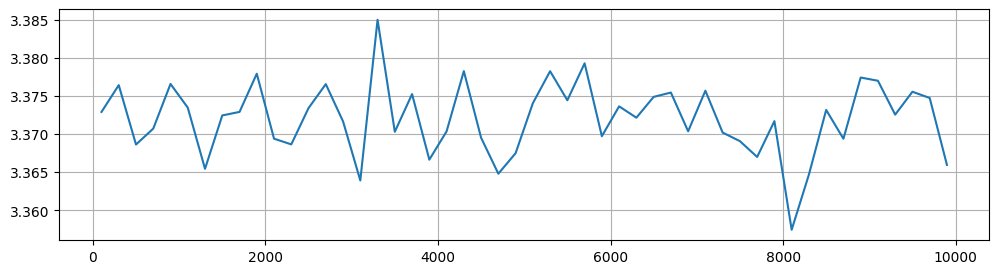

In [206]:
group_size = 200
plt.figure(figsize=(12,3))
plt.plot(
    torch.arange(len(lossi)).view(-1, group_size).float().mean(1),
    torch.tensor(lossi).view(-1, group_size).mean(1)
)
plt.grid()
plt.show()

## compute loss on train/dev/test

In [203]:
model.eval()

Sequential(
  (0): Embedding(27, 10)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=80, out_features=68, bias=False)
  (3): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Tanh()
  (5): Linear(in_features=68, out_features=27, bias=True)
)

In [193]:
def eval_dataset(X, Y):
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [62]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

1.9229323863983154
2.02085280418396


In [204]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

3.371643304824829
3.3723974227905273
